## LSTM Ethereum Classic Autoencoder
This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [728]:
# import libraries
import os
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from google.cloud import bigquery
import matplotlib.pyplot as plt
import plotly.io as pio
from datetime import date
import datetime
pio.renderers.default = 'iframe_connected'
sns.set(color_codes=True)
%matplotlib inline

# model parameters
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model

# Setup tensorflow GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [729]:
# Constants
DATA_COLUMNS = [ 'average_block_size', 'average_gas', 'average_difficulty', 'average_transactions', 'total_gas', 'total_transactions' ] 
DAILY_COLUMNS = [ 'date' ] + DATA_COLUMNS
WINDOW_SIZE = 3
QUANTILE_WINDOW = 3
QUANTILE_RATIO = 0.250
QUANTILE_INTERPOLATION = 'linear'

In [730]:
# set random seed
seed(42)
tf.random.set_seed(42)

# Data loading and pre-processing
Load the data between 08/01/2015 to 07/30/2016 via Big Query

In [731]:
csv_file_name = 'Ethereum_Classic_data.csv'
if os.path.isfile(csv_file_name):
  df = pd.read_csv( csv_file_name )
else:
  # Load the ethereum classic data
  # This requires an environmental variable GOOGLE_APPLICATION_CREDENTIALS to the json file
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/git/machine-learning-api-328501-08fa61aa9f73.json"
  client = bigquery.Client()
  ethereum_classic_dataset_ref = client.dataset('crypto_ethereum_classic', project='bigquery-public-data')

  query = """
  SELECT timestamp, number, difficulty, size, gas_used, transaction_count
  FROM
    `bigquery-public-data.crypto_ethereum_classic.blocks` AS blocks
  WHERE timestamp BETWEEN "2015-08-08 00:00:00+00:00" AND "2016-08-30 23:59:59+00:00"
  ORDER BY timestamp
  """

  query_job = client.query (query)
  iterator = query_job.result()
  rows = list(iterator)

  # Transform the rows into a nice pandas dataframe
  df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
  df.to_csv( csv_file_name )

# convert the timestamps into date time timestamps 
df['timestamp'] = df['timestamp'].apply(lambda x : pd.to_datetime(str(x)))

# create the date field to allow for easy boxing of data into dates
df['dates'] = df['timestamp'].dt.date

df

,Unnamed: 0,timestamp,number,difficulty,size,gas_used,transaction_count,dates
0,0,2015-08-08 00:00:09+00:00,50614,1531187246378,527,0,0,2015-08-08
1,1,2015-08-08 00:00:20+00:00,50615,1531934896400,541,0,0,2015-08-08
2,2,2015-08-08 00:00:55+00:00,50616,1531186881314,541,0,0,2015-08-08
3,3,2015-08-08 00:00:58+00:00,50617,1531934531158,546,0,0,2015-08-08
4,4,2015-08-08 00:01:08+00:00,50618,1532682546065,543,0,0,2015-08-08
...,...,...,...,...,...,...,...,...
2116358,2116358,2016-08-30 23:59:03+00:00,2166972,7802414907554,543,0,0,2016-08-30
2116359,2116359,2016-08-30 23:59:22+00:00,2166973,7802415431842,539,0,0,2016-08-30
2116360,2116360,2016-08-30 23:59:35+00:00,2166974,7802415956130,770,42000,2,2016-08-30
2116361,2116361,2016-08-30 23:59:39+00:00,2166975,7806226253834,541,0,0,2016-08-30


In [732]:
# create new dataframe for daily data
daily_df = pd.DataFrame( columns=DAILY_COLUMNS )

# return the daily data
def obtain_daily_data( input_df ):
    ''' return the daily data '''
    return [ date, 
        input_df['size'].mean(), 
        input_df['gas_used'].mean(),
        input_df['difficulty'].mean(),
        input_df['transaction_count'].mean(),
        input_df['gas_used'].sum(),
        input_df['transaction_count'].sum() ]

# obtain all the dates
all_dates = df['dates'].unique()

for date in all_dates:
    # obtain all data for the date
    daily_df =  pd.concat([daily_df, pd.DataFrame( [ obtain_daily_data( df.loc[df['dates'] == date] ) ],
             columns=DAILY_COLUMNS )], ignore_index=True )
    
daily_df


,date,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions
0,2015-08-08,667.594749,71538.449962,1.586124e+12,0.548135,376006093,2881
1,2015-08-09,618.298068,7585.985360,1.709480e+12,0.259418,38863003,1329
2,2015-08-10,631.186108,14095.159087,1.837696e+12,0.387631,74070061,2037
3,2015-08-11,692.014015,30962.450758,2.036391e+12,0.939962,163481740,4963
4,2015-08-12,653.426425,13681.173302,2.207080e+12,0.397346,70102332,2036
...,...,...,...,...,...,...,...
384,2016-08-26,850.627331,56549.780822,8.514138e+12,2.040271,342635122,12362
385,2016-08-27,834.349645,50543.872376,8.797646e+12,1.925938,305739884,11650
386,2016-08-28,836.794123,51550.059614,8.512523e+12,1.966079,306980605,11708
387,2016-08-29,863.529560,57440.949925,8.167246e+12,1.970859,342979912,11768


## Moving Quantile Average
Let’s get the moving quantile average

In [733]:
# obtain the rolling quantile
daily_norm_df = daily_df.rolling(window=QUANTILE_WINDOW, center=False).quantile(QUANTILE_RATIO, interpolation=QUANTILE_INTERPOLATION)
daily_norm_df['date'] = daily_df['date']

# drop NaN
daily_norm_df = daily_norm_df.dropna()
daily_norm_df.index = daily_norm_df.index - min(daily_norm_df.index)
daily_norm_df

,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions,date
0,624.742088,10840.572223,1.647802e+12,0.323525,56466532.0,1683.0,2015-08-10
1,624.742088,10840.572223,1.773588e+12,0.323525,56466532.0,1683.0,2015-08-11
2,642.306267,13888.166194,1.937043e+12,0.392488,72086196.5,2036.5,2015-08-12
3,659.574355,15186.603204,2.121735e+12,0.467496,79168209.5,2439.0,2015-08-13
4,656.588922,13618.562378,2.272030e+12,0.467496,74424427.0,2439.0,2015-08-14
...,...,...,...,...,...,...,...
382,868.991481,59860.986855,8.435192e+12,2.108970,357833460.5,12626.0,2016-08-26
383,842.488488,53546.826599,8.435192e+12,1.983104,324187503.0,12006.0,2016-08-27
384,835.571884,51046.965995,8.513331e+12,1.946009,306360244.5,11679.0,2016-08-28
385,835.571884,51046.965995,8.339884e+12,1.946009,306360244.5,11679.0,2016-08-29


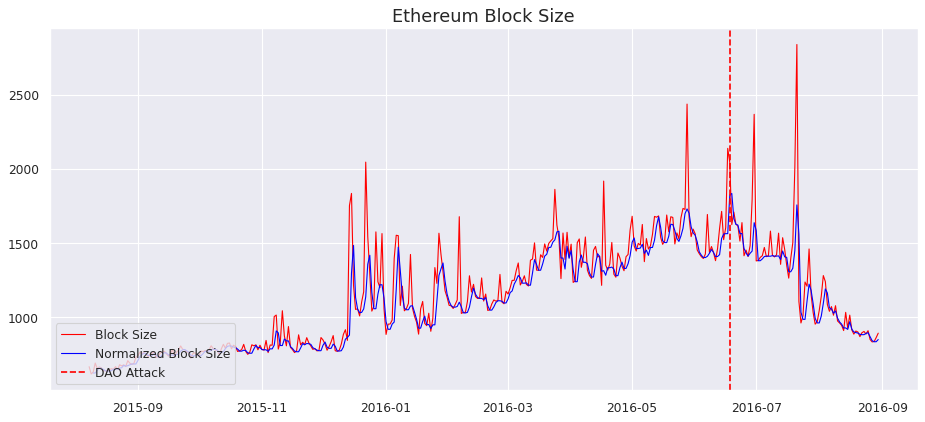

In [734]:
# Average Block Size
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['average_block_size'], label='Block Size', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_block_size'], label='Normalized Block Size', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Block Size', fontsize=16)
plt.show()


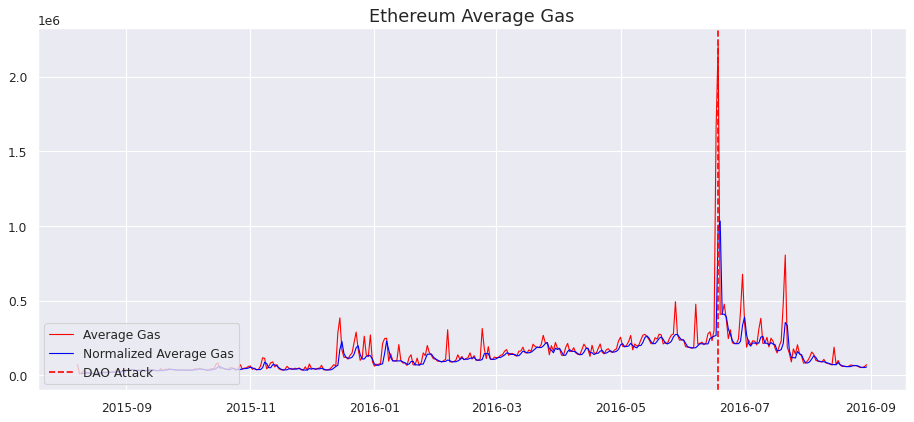

In [735]:
# Average Gas
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['average_gas'], label='Average Gas', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_gas'], label='Normalized Average Gas', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Average Gas', fontsize=16)
plt.show()

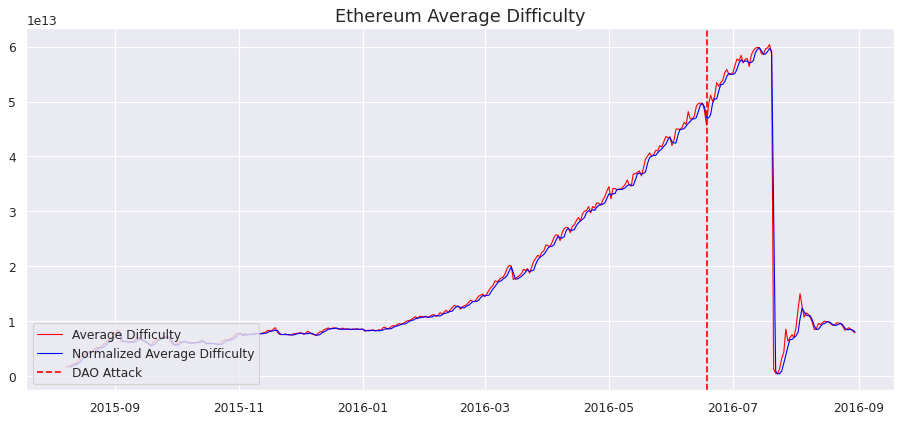

In [736]:
# Average Difficulty
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['average_difficulty'], label='Average Difficulty', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_difficulty'], label='Normalized Average Difficulty', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Average Difficulty', fontsize=16)
plt.show()

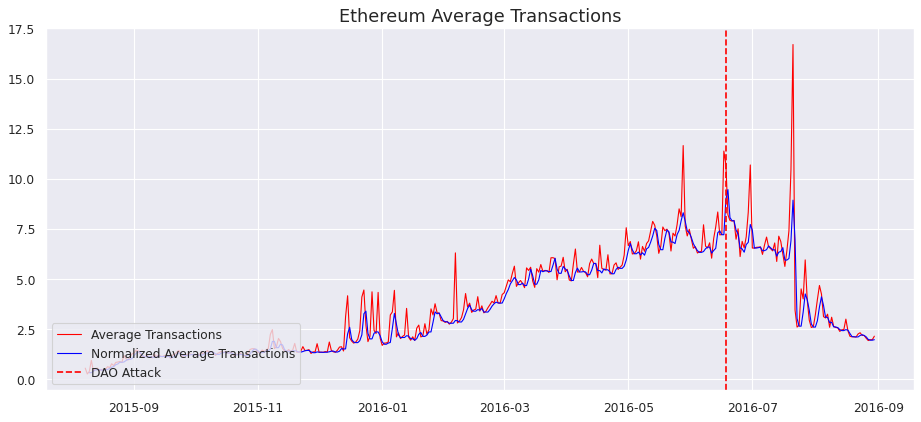

In [737]:
# Average Transactions
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['average_transactions'], label='Average Transactions', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_transactions'], label='Normalized Average Transactions', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Average Transactions', fontsize=16)
plt.show()

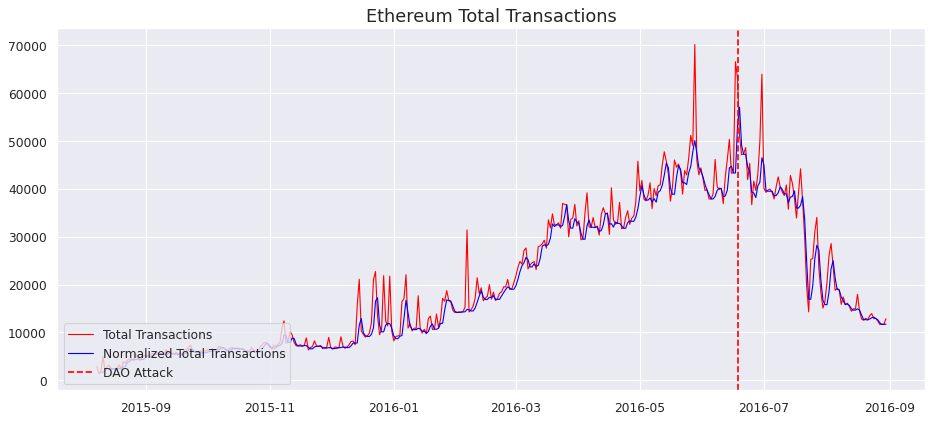

In [738]:
# Total Total Transactions
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['total_transactions'], label='Total Transactions', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['total_transactions'], label='Normalized Total Transactions', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Total Transactions', fontsize=16)
plt.show()

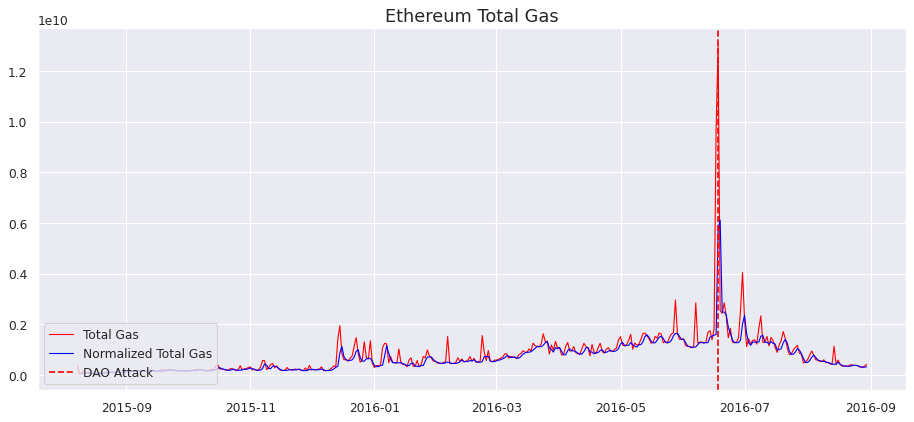

In [739]:
# Total Gas
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_df['date'], daily_df['total_gas'], label='Total Gas', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['total_gas'], label='Normalized Total Gas', color='blue', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Ethereum Total Gas', fontsize=16)
plt.show()

## Normalization
Normalize the daily data by the maximum value for the column

In [740]:
# normalize the data by dividing the value by the maximum value
for field in DATA_COLUMNS:
    norm_value = 10 ** (math.floor(math.log(max_value, 10)) )

    # normalize
    max_value = daily_df[ field ].max()
    min_value = daily_df[ field ].min()
    daily_df[ field ] = ( daily_df[ field ] - min_value ) / ( max_value - min_value )

    # standardize
    mean_value = daily_df[ field ].mean()
    std_value = daily_df[ field ].std()
    daily_norm_df[ field ] = ( ( daily_df[ field ] - mean_value ) / std_value )

daily_norm_df


,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions,date
0,-1.341653,-0.419547,-1.034760,-1.263536,-0.432622,-1.211809,2015-08-10
1,-1.479680,-0.804781,-1.027250,-1.379101,-0.78258,-1.316191,2015-08-11
2,-1.443594,-0.765572,-1.019445,-1.327781,-0.746035,-1.268573,2015-08-12
3,-1.273282,-0.663967,-1.007348,-1.106699,-0.653224,-1.071782,2015-08-13
4,-1.381323,-0.768065,-0.996957,-1.323893,-0.750153,-1.268641,2015-08-14
...,...,...,...,...,...,...,...
382,-0.726342,-0.469943,-0.577902,-0.609187,-0.435709,-0.538642,2016-08-26
383,-0.663286,-0.464868,-0.622601,-0.611279,-0.428352,-0.535884,2016-08-27
384,-0.829178,-0.509835,-0.612989,-0.666275,-0.467261,-0.574153,2016-08-28
385,-0.874754,-0.546013,-0.595729,-0.712040,-0.505559,-0.622039,2016-08-29


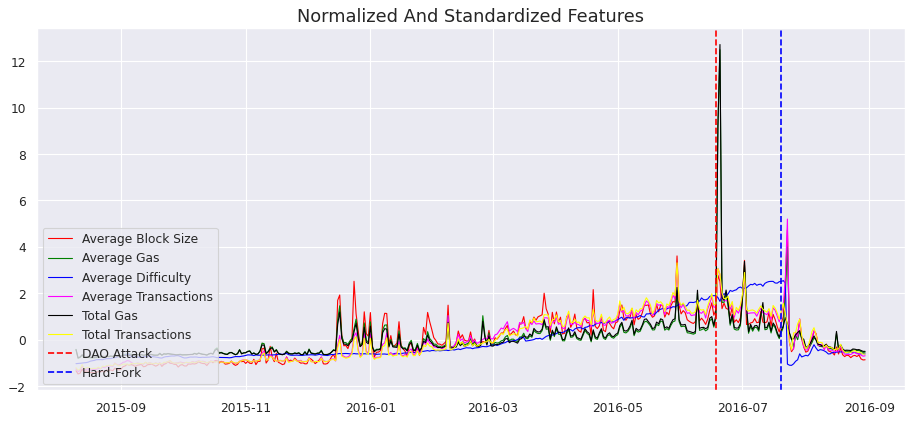

In [741]:
# Plot Standardized Data
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_norm_df['date'], daily_norm_df['average_block_size'], label='Average Block Size', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_gas'], label='Average Gas', color='green', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_difficulty'], label='Average Difficulty', color='blue', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['average_transactions'], label='Average Transactions', color='magenta', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['total_gas'], label='Total Gas', color='black', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'], daily_norm_df['total_transactions'], label='Total Transactions', color='yellow', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.axvline(datetime.date(2016,7,20), color='blue', linestyle='dashed', label='Hard-Fork')
plt.legend(loc='lower left')
ax.set_title('Normalized And Standardized Features', fontsize=16)
plt.show()

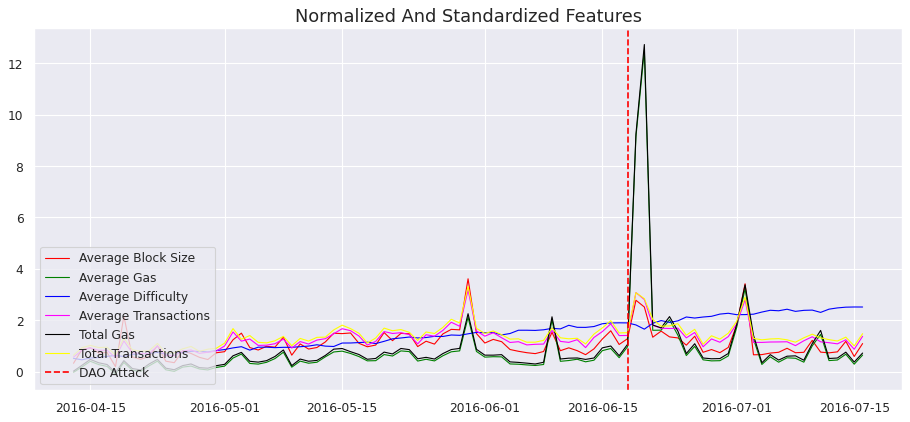

In [742]:
# Plot Standardized Data for T1
mask = (daily_norm_df['date'] > datetime.date(2016,4,12)) & (daily_norm_df['date'] <= datetime.date(2016,7,16))
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['average_block_size'][mask], label='Average Block Size', color='red', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['average_gas'][mask], label='Average Gas', color='green', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['average_difficulty'][mask], label='Average Difficulty', color='blue', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['average_transactions'][mask], label='Average Transactions', color='magenta', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['total_gas'][mask], label='Total Gas', color='black', animated = True, linewidth=1)
ax.plot(daily_norm_df['date'][mask], daily_norm_df['total_transactions'][mask], label='Total Transactions', color='yellow', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')
plt.legend(loc='lower left')
ax.set_title('Normalized And Standardized Features', fontsize=16)
plt.show()

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

Let's change the data over from a block by block basis to a daily basis

In [743]:
# separate into training and testing
split_date = datetime.date(2016,4,12)
daily_norm_df_training = daily_norm_df.loc[daily_norm_df['date'] <= split_date]
daily_norm_df_test = daily_norm_df.loc[daily_norm_df['date'] > split_date]

# separate the date field 
print( f'Training Data Shape: {daily_norm_df_training.shape}')
print( f'Test Data Shape: {daily_norm_df_test.shape}')

Training Data Shape: (247, 7)
Test Data Shape: (140, 7)


In [744]:
daily_norm_df_training

,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions,date
0,-1.341653,-0.419547,-1.034760,-1.263536,-0.432622,-1.211809,2015-08-10
1,-1.479680,-0.804781,-1.027250,-1.379101,-0.78258,-1.316191,2015-08-11
2,-1.443594,-0.765572,-1.019445,-1.327781,-0.746035,-1.268573,2015-08-12
3,-1.273282,-0.663967,-1.007348,-1.106699,-0.653224,-1.071782,2015-08-13
4,-1.381323,-0.768065,-0.996957,-1.323893,-0.750153,-1.268641,2015-08-14
...,...,...,...,...,...,...,...
242,0.531983,0.099242,0.431270,0.655624,0.159665,0.75187,2016-04-08
243,0.721371,0.118381,0.368758,0.661506,0.170951,0.739428,2016-04-09
244,1.103475,0.256111,0.460051,0.748011,0.340649,0.881809,2016-04-10
245,0.478839,0.046001,0.502883,0.670759,0.093613,0.741446,2016-04-11


In [745]:
daily_norm_df_test

,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions,date
247,0.322225,-0.029069,0.513159,0.561706,0.01743,0.634105,2016-04-13
248,0.853098,0.176948,0.457344,0.824399,0.242007,0.9264,2016-04-14
249,0.925528,0.399823,0.527219,0.916099,0.473017,1.019079,2016-04-15
250,0.724720,0.271758,0.545609,0.829280,0.341438,0.933664,2016-04-16
251,0.743231,0.200006,0.591954,0.826537,0.273871,0.945636,2016-04-17
...,...,...,...,...,...,...,...
382,-0.726342,-0.469943,-0.577902,-0.609187,-0.435709,-0.538642,2016-08-26
383,-0.663286,-0.464868,-0.622601,-0.611279,-0.428352,-0.535884,2016-08-27
384,-0.829178,-0.509835,-0.612989,-0.666275,-0.467261,-0.574153,2016-08-28
385,-0.874754,-0.546013,-0.595729,-0.712040,-0.505559,-0.622039,2016-08-29


In [746]:
# separate the date from the training and test data
train_data = daily_norm_df_training.drop(columns=['date']).copy()
test_data = daily_norm_df_test.drop(columns=['date']).copy()

# convert to numpy array
train_data = train_data.values 
test_data = test_data.values
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Training data shape: (247, 6)
Test data shape: (140, 6)


In [747]:
def obtain_window_data( input_data, window_size ):
    '''return the data in the overlapping windows'''
    output = []
    for i in range(window_size,len(input_data)):
        output.append(input_data[i-window_size:i,:])
    return np.asarray(output).astype('float32')

# split the data into overlapping windows with a stride of 1
X_train = obtain_window_data( train_data, WINDOW_SIZE )

X_test = obtain_window_data( test_data, WINDOW_SIZE )
X_train.shape

(244, 3, 6)

In [748]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True)(inputs)
    L2 = Dropout(0.1)(L1)
    L3 = LSTM(16, activation='relu', return_sequences=True)(L2)
    L4 = LSTM(8, activation='relu')(L3)
    L5 = RepeatVector(X.shape[1])(L4)
    L6 = LSTM(8, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(16, activation='relu', return_sequences=True)(L6)
    L8 = Dropout(0.1)(L7)
    L9 = LSTM(32, activation='relu', return_sequences=True)(L8)
    output = TimeDistributed(Dense(X.shape[2]))(L9)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [749]:
# create the autoencoder model
model = autoencoder_model(X_train)

# compile the model
model.compile(optimizer='adam',
              loss='msle',
              metrics=['mse'])

model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 3, 6)]            0         
                                                                 
 lstm_132 (LSTM)             (None, 3, 32)             4992      
                                                                 
 dropout_44 (Dropout)        (None, 3, 32)             0         
                                                                 
 lstm_133 (LSTM)             (None, 3, 16)             3136      
                                                                 
 lstm_134 (LSTM)             (None, 8)                 800       
                                                                 
 repeat_vector_22 (RepeatVec  (None, 3, 8)             0         
 tor)                                                            
                                                          

In [750]:
# fit the model to the data
batch_size = 32
nb_epochs = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
8/8 [==============================] - 4s 113ms/step - loss: 0.0281 - mse: 0.5168 - val_loss: 0.1950 - val_mse: 0.3670
Epoch 2/100
8/8 [==============================] - 0s 60ms/step - loss: 0.0271 - mse: 0.5248 - val_loss: 0.1877 - val_mse: 0.3570
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 0.0264 - mse: 0.5341 - val_loss: 0.1800 - val_mse: 0.3461
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 0.0258 - mse: 0.5420 - val_loss: 0.1745 - val_mse: 0.3380
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 0.0255 - mse: 0.5478 - val_loss: 0.1706 - val_mse: 0.3323
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0253 - mse: 0.5520 - val_loss: 0.1677 - val_mse: 0.3279
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0251 - mse: 0.5569 - val_loss: 0.1635 - val_mse: 0.3216
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0250 - mse: 0.5

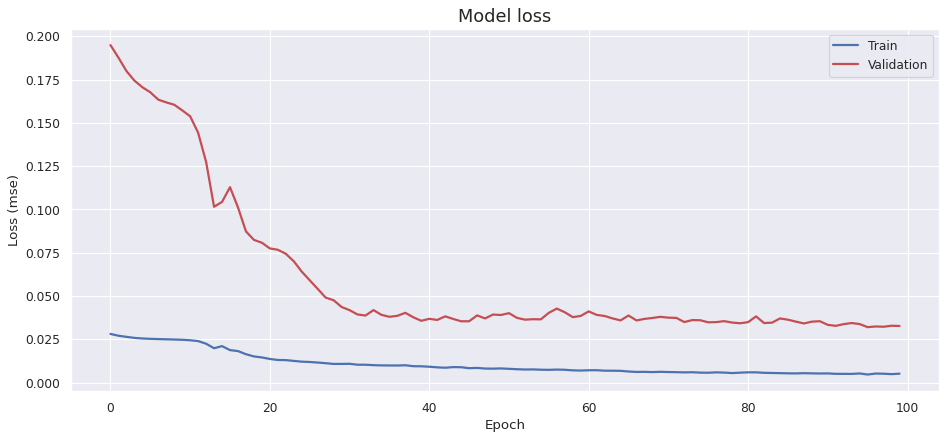

In [751]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [752]:
# account for the overlapping windows and average the values
def average_predicted_data( input_data, data_columns=DATA_COLUMNS ):
    '''return the data in the overlapping windows'''
    dataframes = []
    for i in range(0,len(input_data)):
        for j in range( 0, input_data.shape[1] ):
            dataframes.append( pd.DataFrame( [input_data[i][j]], columns=data_columns, index=[i + j] ) )
    # combine
    comb_df = pd.concat(dataframes)
    return comb_df.groupby(comb_df.index).mean()

In [753]:
# for some reason, the last row is dropped...
X_compare_train = daily_norm_df_training.drop(daily_norm_df_training.tail(1).index)
X_compare_train.shape

(246, 7)

In [754]:
# also drop the last row in the test data and reset the index to 0
X_compare_test = daily_norm_df_test.drop(daily_norm_df_test.tail(1).index)
X_compare_test.index = X_compare_test.index - min(X_compare_test.index)


In [755]:
# obtain the predicted values
X_pred = model.predict(X_train)

# reformat the data and take the averages of overlapping windows
X_compare_pred = average_predicted_data( X_pred )

# Add the date column back
X_compare_pred['date'] = X_compare_train['date']

In [756]:
def calculate_delta_dataframe( predicted, truth, data_columns=DATA_COLUMNS ):
    '''calculate the delta between the dataframes and return a norm dataframe'''
    tmp_df = pd.DataFrame()

    for data_field in data_columns:
        tmp_df[ data_field ] = predicted[ data_field ] - truth[ data_field ]

    # calculate the norm of the row
    delta_np = np.sqrt(np.square(tmp_df).sum(axis=1))
    output = pd.DataFrame( delta_np, columns = ['delta'])
    output['date'] = truth['date']
    return output

delta_df_norm = calculate_delta_dataframe( X_compare_pred, X_compare_train )

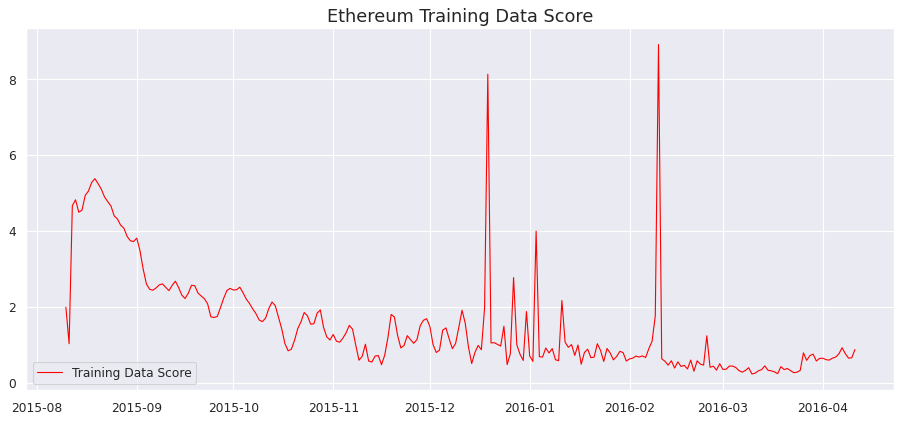

In [757]:
# Delta Plot ( for the training data )
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(delta_df_norm['date'], delta_df_norm['delta'], label='Training Data Score', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Ethereum Training Data Score', fontsize=16)
plt.show()

## Test Data

In [758]:
# obtain the predicted values
X_pred_test = model.predict(X_test)

# reformat the data and take the averages of overlapping windows
X_compare_pred_test = average_predicted_data( X_pred_test )

# Add the date column back
X_compare_pred_test['date'] = X_compare_test['date']
X_compare_pred_test

,average_block_size,average_gas,average_difficulty,average_transactions,total_gas,total_transactions,date
0,0.536346,0.165291,-0.040580,0.313919,0.136426,0.253502,2016-04-13
1,0.920100,0.308893,-0.092119,0.503185,0.285832,0.476928,2016-04-14
2,1.114668,0.382288,-0.143219,0.642551,0.379850,0.660608,2016-04-15
3,1.051523,0.337238,-0.183489,0.671999,0.349167,0.721546,2016-04-16
4,0.886670,0.277542,-0.187671,0.609010,0.273241,0.638128,2016-04-17
...,...,...,...,...,...,...,...
134,-0.341503,-0.284841,-0.161044,-0.406137,-0.158298,-0.548746,2016-08-25
135,-0.340263,-0.282480,-0.160700,-0.404330,-0.157536,-0.545797,2016-08-26
136,-0.360287,-0.299004,-0.169171,-0.433244,-0.163657,-0.582112,2016-08-27
137,-0.644098,-0.541478,-0.278586,-0.783099,-0.269286,-1.031469,2016-08-28


In [759]:
# calculate the delta
delta_test_df_norm = calculate_delta_dataframe( X_compare_pred_test, X_compare_test, DATA_COLUMNS )

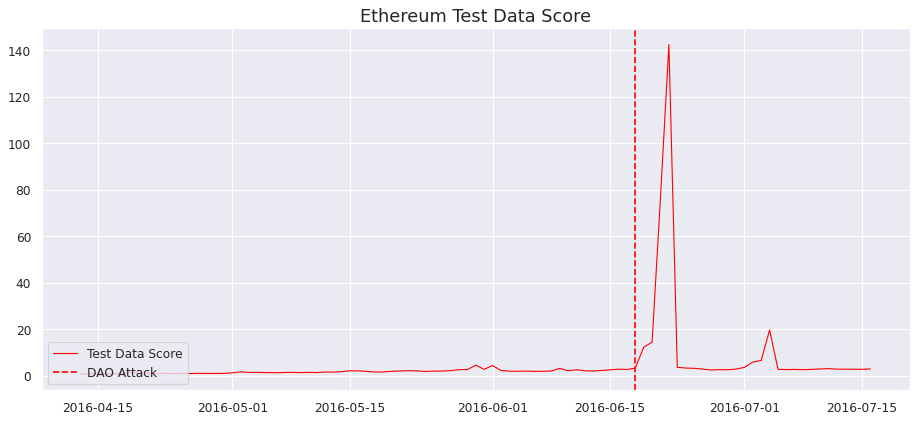

In [760]:
# Delta Plot ( for the training data )
mask = (delta_test_df_norm['date'] > datetime.date(2016,4,12)) & (delta_test_df_norm['date'] <= datetime.date(2016,7,16))
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(delta_test_df_norm['date'][mask], delta_test_df_norm['delta'][mask], label='Test Data Score', color='red', animated = True, linewidth=1)
plt.axvline(datetime.date(2016,6,18), color='red', linestyle='dashed', label='DAO Attack')

plt.legend(loc='lower left')
ax.set_title('Ethereum Test Data Score', fontsize=16)
plt.show()